In [15]:
import random

import xarray as xr
import numpy as np
import xgcm 
from matplotlib import pyplot as plt
from matplotlib import image
import cmocean
import cartopy.crs as ccrs
import datetime
year = datetime.datetime.now().year
%matplotlib inline

In [2]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")
list(cat)

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


['LLC4320_grid',
 'LLC4320_SST',
 'LLC4320_SSS',
 'LLC4320_SSH',
 'LLC4320_SSU',
 'LLC4320_SSV']

In [3]:
grid_full = cat.LLC4320_grid.to_dask()
grid_full

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 ...
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 ...
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacS    (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacW    (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    k        int64 ...
    k_l      int64 ...
  * k_p1     (k_p1) int64 0 1
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [4]:
seed = 3
nside = 1080
random.seed(seed)

In [5]:
nt = random.randint(0, grid_full.dims['time'])
nface = random.randint(0, grid_full.dims['face'])

frac_ocean = 0.
frac_ocean_thresh = 0.3
while frac_ocean < frac_ocean_thresh:
    i_offset = random.randint(0, grid_full.dims['i'] // nside)
    j_offset = random.randint(0, grid_full.dims['j'] // nside)
    i_slice = slice(nside * i_offset, nside * (i_offset + 1)) 
    j_slice = slice(nside * j_offset, nside * (j_offset + 1))
    selector = dict(time=nt, face=nface, i=i_slice, j=j_slice,
                    i_g=i_slice, j_g=j_slice)
    grid_ds = grid_full.isel(**selector)
    frac_ocean = grid_ds.hFacC.mean().values.item()
    if np.isnan(frac_ocean):
        frac_ocean = 0.
frac_ocean

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1.0

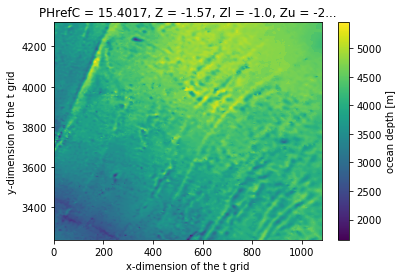

In [6]:
grid_ds.Depth.plot()

In [7]:
ssh = cat.LLC4320_SSH(chunks=False).to_dask().isel(time=nt, face=nface, i=i_slice, j=j_slice)
sst = cat.LLC4320_SST(chunks=False).to_dask().isel(time=nt, face=nface, i=i_slice, j=j_slice)
# sss has some extra metadata
sss = cat.LLC4320_SSS(chunks=False).to_dask().isel(time=nt, face=nface, i=i_slice, j=j_slice)[['SSS']].reset_coords(drop=True)
u = cat.LLC4320_SSU(chunks=False).to_dask().isel(time=nt, face=nface, i_g=i_slice, j=j_slice)
v = cat.LLC4320_SSV(chunks=False).to_dask().isel(time=nt, face=nface, i=i_slice, j_g=j_slice)
ds = xr.merge([grid_ds, ssh, sst, sss, u, v])
# vertical coordiantes are not helpful
ds = ds.drop(['Z', 'Zl', 'Zp1', 'Zu', 'k', 'k_l', 'k_p1', 'PHrefF', 'drC'])
ds

<xarray.Dataset>
Dimensions:  (i: 1080, i_g: 1080, j: 1080, j_g: 1080)
Coordinates:
    CS       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    PHrefC   float32 ...
    SN       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    drF      float32 ...
    dxC      (j, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face     int64 9
    hFacC    (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
  * j        (j) int64 3240 3241 3242 3243 3244 ... 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 3240 3241 3242 3243 3244 ... 4315 4316 4317 4318 4319
    k_u      int64 ...
    rA       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    time     datetime64[ns] 2012-02-22T10:00:00
Data variables:
    Eta      (j, i) float32 ...
    SST      (j, i) float32 ...
    SSS      (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...

In [8]:
grid = xgcm.Grid(ds, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic):
  * center   j --> left
  * left     j_g --> center

In [9]:
ds['eke'] = 0.5 * (grid.interp(ds.U**2, 'X', boundary='extend')
             + grid.interp(ds.V**2, 'Y', boundary='extend'))

ds['zeta'] = 1e4 * (-grid.diff(ds.U * ds.dxC, 'Y', boundary='extend') +
                    grid.diff(ds.V * ds.dyC, 'X', boundary='extend'))/ds.rAz

ds['div'] = (grid.diff(ds.U * ds.dxC, 'X', boundary='extend') +
             grid.diff(ds.V * ds.dyC, 'Y', boundary='extend'))/ds.rA

In [10]:
# fix some metadata
ds.zeta.attrs['units'] = r'$10^{-4}$ s$^{-1}$'
ds.zeta.attrs['long_name'] = 'Vorticity'

ds.SST.attrs['units'] = r'$^\circ$C'
ds.SST.attrs['long_name'] = 'Sea Surface Temperature'

ds.SSS.attrs['units'] = r'PSU'
ds.SSS.attrs['long_name'] = 'Sea Surface Salinity'

ds.Eta.attrs['units'] = r'm'
ds.Eta.attrs['long_name'] = 'Sea Surface Height'

In [11]:
central_lon = ds.XC.mean().values.item()
central_lat = ds.YC.mean().values.item()

lon_min = ds.XC.min().values.item()
lon_max = ds.XC.max().values.item()
lon_range = lon_max - lon_min

lat_min = ds.YC.min().values.item()
lat_max = ds.YC.max().values.item()
lat_range = lat_max - lat_min

proj = ccrs.Orthographic(central_longitude=central_lon,
                         central_latitude=central_lat)

date_str = np.datetime_as_string(ds.time.values, timezone='UTC', unit='m')

location = f'({central_lon:3.2f}, {central_lat:3.2f}) | {date_str}'
print(location)

(-139.25, -62.41) | 2012-02-22T10:00Z


In [12]:
# tiles near equator are square
# towards pole, both dimensions contract
scale_lon = 2 + 0.75 * abs(np.deg2rad(central_lat))
scale_lat = 2 + 0.3 * abs(np.deg2rad(central_lat))

print(scale_lon, scale_lat)

extent = [central_lon - lon_range/scale_lon, central_lon + lon_range/scale_lon,
          central_lat - lat_range/scale_lat, central_lat + lat_range/scale_lat]

2.8169966196655087 2.3267986478662035


In [18]:
plt.rcParams['font.size'] = 16

def plot(da, clip_extent=True, **kwargs):
    xdim = 'XC' if 'i' in da.dims else 'XG'
    ydim = 'YC' if 'j' in da.dims else 'YG'
    
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_axes([0, 0.02, 1, 0.91],
                      projection=ccrs.Orthographic(central_lon, central_lat))
    ax.background_patch.set_facecolor('0.6')
    if clip_extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines()
    
    da.plot(ax=ax, x=xdim, y=ydim, transform=ccrs.PlateCarree(), **kwargs)
    ax.set_title(f'LLC4320 {da.long_name} | {location}')
    
    logo_axis = fig.add_axes([0.81, 0.017, 0.12, 0.05])
    fig.text(0.815, 0.1, f'© Ryan Abernathey\n{year} CC BY',
             fontdict={'size': 11})
    img = image.imread('pangeo_logo.png')
    logo_axis.imshow(img, interpolation='hanning')
    logo_axis.axis('off')


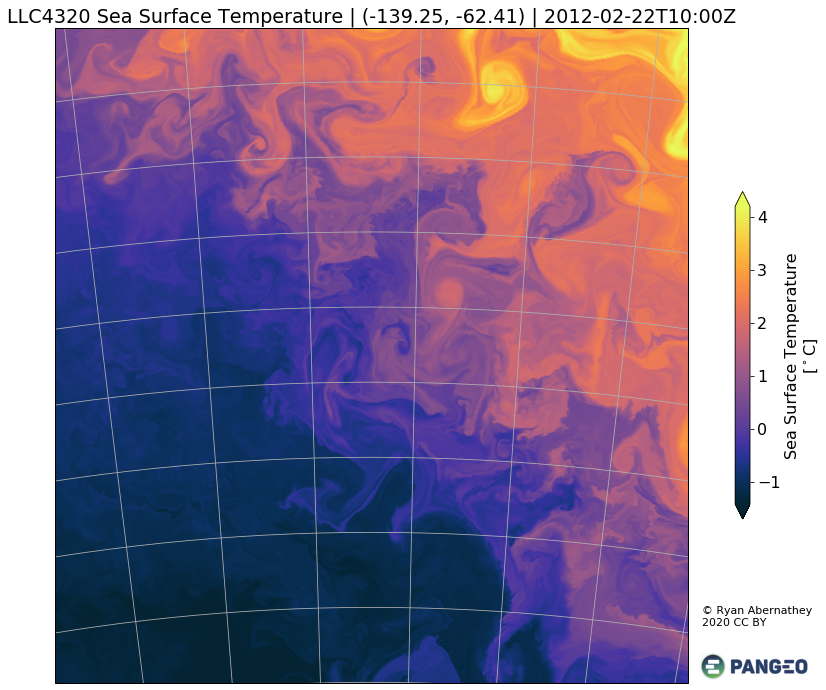

In [19]:
plot(ds.SST, center=False, robust=True, cmap=cmocean.cm.thermal,
     cbar_kwargs={'shrink': 0.5})
plt.savefig('SST.png')

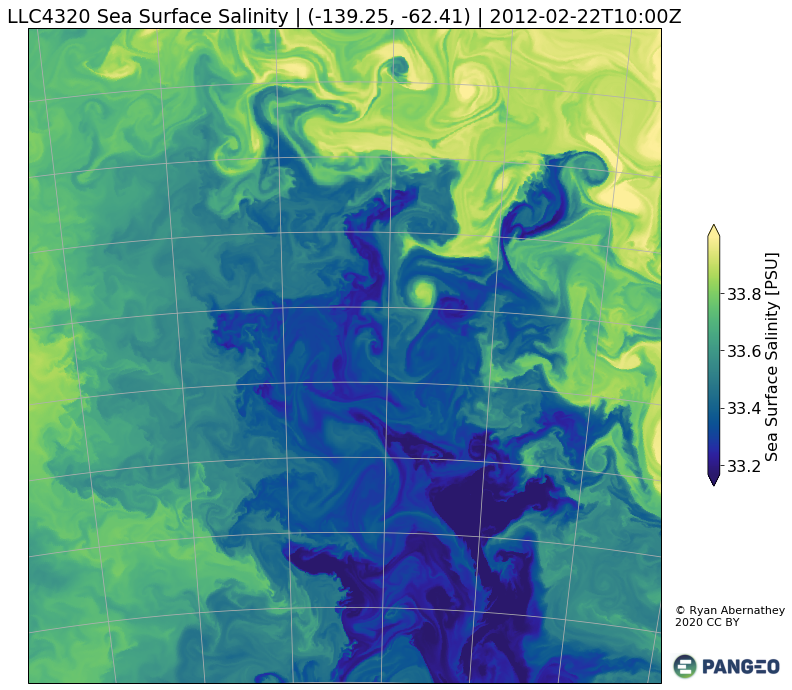

In [20]:
plot(ds.SSS, center=False, robust=True, cmap=cmocean.cm.haline,
     cbar_kwargs={'shrink': 0.4})

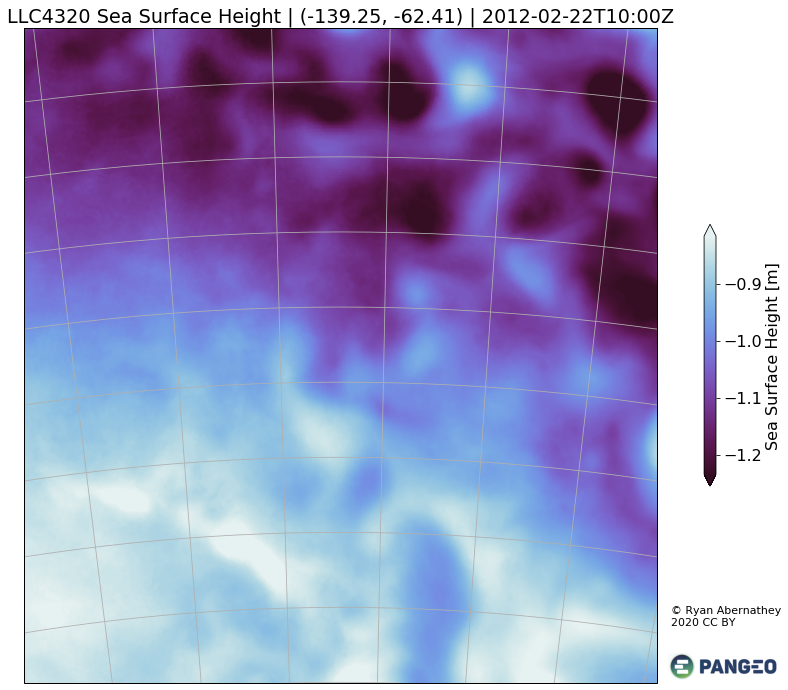

In [21]:
plot(ds.Eta, center=False, robust=True, cmap=cmocean.cm.dense_r,
     cbar_kwargs={'shrink': 0.4})

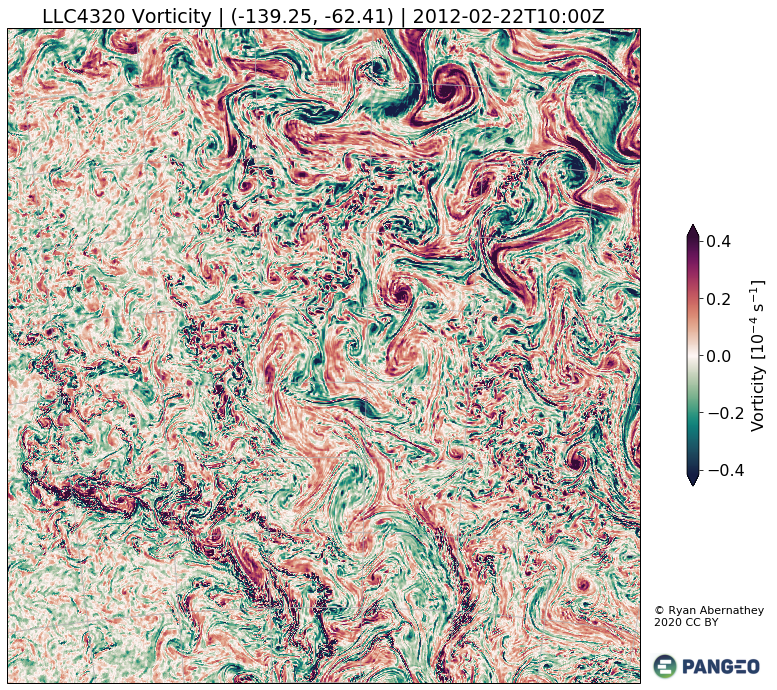

In [22]:
plot(ds.zeta, robust=True, cmap=cmocean.cm.curl, cbar_kwargs={'shrink': 0.4})